First some installation requirements (only run this once)

In [ ]:
!pip3 install --user https://github.com/google/qkeras/archive/master.zip
!curl https://raw.githubusercontent.com/fastmachinelearning/hls4ml-tutorial/master/callbacks.py > callbacks.py
!curl https://raw.githubusercontent.com/fastmachinelearning/hls4ml-tutorial/master/plotting.py > plotting.py

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

## Fetch the jet tagging dataset from Open ML (run this only once, this can take a while)

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [3]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
[[-2.93512535e+00  3.83155316e-01  5.12587558e-03  8.42466834e-05
   9.06995591e-03  1.78931368e-04  1.76944518e+00  2.12389827e+00
   1.76944518e+00  3.08185428e-01  1.35686919e-01  8.32780078e-02
   4.12136108e-01  2.99057871e-01  8.92688179e+00  7.50000000e+01]
 [-1.92733514e+00  2.70698756e-01  1.58540264e-03  1.13709866e-05
   3.23237223e-03  2.91449633e-05  2.03883362e+00  2.56309891e+00
   2.03883362e+00  2.11886495e-01  6.37285784e-02  3.63104008e-02
   3.10216516e-01  2.26661310e-01  3.88651156e+00  3.10000000e+01]
 [-3.11214662e+00  4.58171129e-01  9.79138538e-02  2.85884105e-02
   1.24277540e-01  3.84868123e-02  1.26925385e+00  1.34623826e+00
   1.26925385e+00  2.46488109e-01  1.15635969e-01  7.90941268e-02
   3.57558519e-01  2.8

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [4]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [5]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [6]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Get the dataset

In [4]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import setGPU

## Construct a classical model

We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [10]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [12]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_1')
model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)

Epoch 1/30
463/487 [===========================>..] - ETA: 0s - loss: 0.7546 - accuracy: 0.7525
***callbacks***
saving losses to model_1/losses.log

Epoch 00001: val_loss improved from inf to 0.75901, saving model to model_1/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 0.75901, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 0.7544 - accuracy: 0.7526 - val_loss: 0.7590 - val_accuracy: 0.7515
Epoch 2/30
462/487 [===========================>..] - ETA: 0s - loss: 0.7530 - accuracy: 0.7528
***callbacks***
saving losses to model_1/losses.log

Epoch 00002: val_loss improved from 0.75901 to 0.75755, saving model to model_1/KERAS_check_best_model.h5

Epoch 00002: val_loss improved from 0.75901 to 0.75755, saving model to model_1/KERAS_check_b

## Check performance
Check the accuracy and make a ROC curve

Accuracy: 0.7580481927710844


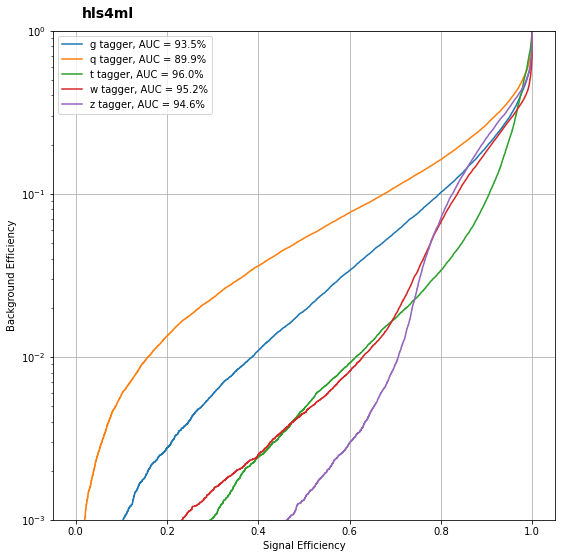

In [13]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)

## Construct a quantized model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google. Recently a support for QKeras model to hls4ml was added.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [15]:
qmodel = Sequential()
qmodel.add(QDense(64, input_shape=(16,), name='fc1',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(QActivation(activation=quantized_relu(6), name='relu1'))
qmodel.add(QDense(32, name='fc2',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(QActivation(activation=quantized_relu(6), name='relu2'))
qmodel.add(QDense(32, name='fc3',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(QActivation(activation=quantized_relu(6), name='relu3'))
qmodel.add(QDense(5, name='output',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='softmax', name='softmax'))

## Train sparse
Let's train with model sparsity again, since QKeras layers are prunable.

In [16]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
qmodel = prune.prune_low_magnitude(qmodel, **pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [17]:
adam = Adam(lr=0.0001)
qmodel.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_3')
callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
qmodel.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    # Save the model again but with the pruning 'stripped' to use the regular layer types
qmodel = strip_pruning(model)

Epoch 1/30
486/487 [============================>.] - ETA: 0s - loss: 0.7245 - accuracy: 0.7603
***callbacks***
saving losses to model_3/losses.log

Epoch 00001: val_loss improved from inf to 0.72965, saving model to model_3/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 0.72965, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_3/KERAS_check_model_last.h5

Epoch 00001: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 6ms/step - loss: 0.7245 - accuracy: 0.7604 - val_loss: 0.7296 - val_accuracy: 0.7593
Epoch 2/30
483/487 [============================>.] - ETA: 0s - loss: 0.7238 - accuracy: 0.7605
***callbacks***
saving losses to model_3/losses.log

Epoch 00002: val_loss improved from 0.72965 to 0.72880, saving model to model_3/KERAS_check_best_model.h5

Epoch 00002: val_loss improved from 0.72965 to 0.72880, saving model to model_3/KERAS_check_b

Accuracy: 0.753343373493976


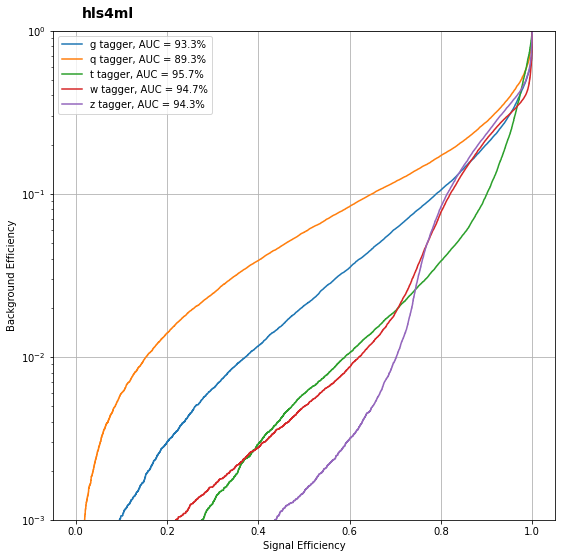

In [18]:
y_qkeras = qmodel.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_test, y_qkeras, le.classes_)